In [1]:
import numpy as np
import torch
from nb_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
import re

%matplotlib inline

In [2]:
cols = sns.color_palette('CMRmap')
col1=cols[1]
cols = sns.color_palette('Wistia')
col2 = cols[-3]
cols = sns.color_palette('Paired')
col3=cols[3]
cols = sns.color_palette('Reds')
col4 = cols[-2]

colors = [col3,col2,col4,col1]
sns.set_palette(sns.color_palette(colors))
cols = sns.color_palette(colors)
cols

In [3]:
def load_info_from_file(npz_path, model_name='ResNet18', **kwargs):
    results_dict = dict(np.load(npz_path))
    lr = np.ones(len(results_dict['report_epochs']))*kwargs.get("lr")
    params_dict = kwargs.get("params_dict")
    
    results_dict["lr"] = lr
    prebn_pnorm_sqr = 0.0
    prebn_numel = 0
    
    for key in list(results_dict.keys()):
        if "acc" in key:
            results_dict[key.replace("acc", "error")] = 1.0 - results_dict[key]  
        elif lr is not None and "_norm" in key and key != "params_norm":
            p_name = key[:-5]
            if check_si_name(p_name, model_name):
                p_norm_sqr = results_dict[key] ** 2
                prebn_pnorm_sqr += p_norm_sqr
                elr = lr / p_norm_sqr
                #print(elr.shape,p_norm_sqr.shape)
                results_dict[key.replace("norm", "elr")] = elr

                if params_dict is not None:
                    p_numel = params_dict[p_name].numel()
                    prebn_numel += p_numel
                    results_dict[key.replace("norm", "elr_unit")] = elr * p_numel
    
    if not isinstance(prebn_pnorm_sqr, float):
        results_dict["prebn_pnorm"] = np.sqrt(prebn_pnorm_sqr)
        elr = lr / prebn_pnorm_sqr
        results_dict["elr"] = elr
        
    return results_dict

def load_info(folder_info,fns,model_name='ResNet18'):
    results_info = {}
    
    for fn in fns:
        result = {'train': None, 'train_prebn': None, 'test': None}
        if 'train-tm.npz' in listdir(folder_info+fn):
                result['train'] = load_info_from_file(folder_info + fn +'/train-tm.npz', 
                                                      model_name=model_name, lr=float(fn.split('_')[3][2:]))
        if 'train-tm-prebn.npz' in listdir(folder_info+fn):
                result['train_prebn'] = load_info_from_file(folder_info + fn +'/train-tm-prebn.npz', 
                                                      model_name=model_name, lr=float(fn.split('_')[3][2:]))
        if 'test-em.npz' in listdir(folder_info+fn):
                result['test'] = load_info_from_file(folder_info + fn +'/test-em.npz', 
                                                      model_name=model_name, lr=float(fn.split('_')[3][2:]))
        results_info[fn] = result
    return results_info

In [4]:
def plot_one_loss_paper(results,fns,data,loss,ax,yscale='log',xscale='log',
                  from_id = None,to_id = None,pts='-',c=None,title = None):
    for fn in fns:
        if results[fn][data] is not None:
            mask = np.ones(len(results[fn][data]['report_epochs']),dtype = bool)
            if from_id is not None:
                mask[results[fn][data]['report_epochs']<from_id] = False
            if to_id is not None:
                mask[results[fn][data]['report_epochs']>to_id] = False
            if loss == 'acc':
                ax.plot(results[fn][data]['report_epochs'][mask], (1-results[fn][data][loss][mask])*100,pts,label = fn,c=c,
                       linewidth=1.3)
            else:
                ax.plot(results[fn][data]['report_epochs'][mask], results[fn][data][loss][mask],pts,label = fn,c=c,
                       linewidth=1.3)
        else:
            ax.plot([],[])

    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
    ax.grid()

    ax.set_xlabel('epoch',fontsize=11)
    if title is not None:
        ax.set_title(title,fontsize=12)
    else:
        if loss == 'acc':
            #ax.set_ylabel('err')
            ax.set_title(data + ' ' + 'err')
        else:
            #ax.set_ylabel(loss)
            ax.set_title(data + ' ' + loss)

In [5]:
def plot_one_grad_diagram_paper(results,fns,t,ax,from_id = None,to_id = None,c=None):
    if t == 0:
        ax.set_title("Phase diagram",fontsize=12)
        ax.set_ylabel(r'mean eff. gradient norm $\mathbb{E}\tilde{g_t}$',fontsize=11)
        ax.set_xlabel("effective learning rate "+r'$\tilde{\eta} $',fontsize=11)
        ax.set(xscale='log', yscale='log')
    else:
        ax.set(title="gnorm_e^2 * elr", xlabel="elr", ylabel="gnorm_e^2 * elr", xscale='log', yscale='log')

    for model in fns:
        label = model
        elr = results[model]['train']["elr"]
        print("gnorm_m" in results[model]['train'].keys())
        if "gnorm_m" in results[model]['train'].keys():
            gnorm = results[model]['train']["gnorm_m"]
            gnorm = gnorm*results[model]['train']["prebn_pnorm"]
        elif "gnorm_e" in results[model]['train'].keys():
            gnorm = results[model]['train']["gnorm_e"]
        elif results[model]['train_prebn'] is not None and "gnorm_m" in results[model]['train_prebn'].keys():
            gnorm = results[model]['train_prebn']["gnorm_m"]
            gnorm = gnorm*results[model]['train_prebn']["prebn_pnorm"]
        else:
            ax.plot([],[]) 
            continue
        report_epochs = list(results[model]['train']["report_epochs"])
        mask = np.ones(len(results[model]['train']['report_epochs']),dtype = bool)
        if from_id is not None:
            mask[results[model]['train']['report_epochs']<from_id] = False
        if to_id is not None:
            mask[results[model]['train']['report_epochs']>to_id] = False
        if t == 0:
            ax.plot(elr[mask], gnorm[mask], '.-', label=label,c=c) 
            ax.plot(elr[mask][0], gnorm[mask][0], '*',c='k',label = 'starting points',markersize=7,alpha=0.8)  
        else:
            elr_by_gnorm = elr * gnorm
            ax.plot(elr[mask], elr_by_gnorm[mask], '.-', label=label,c=c) 
            ax.plot(elr[mask][0], elr_by_gnorm[mask][0], 'r*') 

    ax.grid()

## Fully scale-invariant, ConvNet, CIFAR10 - diff lrs

['c32_d3_ds50000_lr1.0_wd0.001_mom0.0_corr0.0_epoch1001_noschinitscale10.0_noaug', 'c32_d3_ds50000_lr0.03_wd0.001_mom0.0_corr0.0_epoch1001_noschinitscale10.0_noaug', 'c32_d3_ds50000_lr0.01_wd0.001_mom0.0_corr0.0_epoch10001_noschinitscale10.0_noaug', 'c32_d3_ds50000_lr0.001_wd0.001_mom0.0_corr0.0_epoch10001_noschinitscale10.0_noaug']
True
True
True
True


(11.53, 65.0)

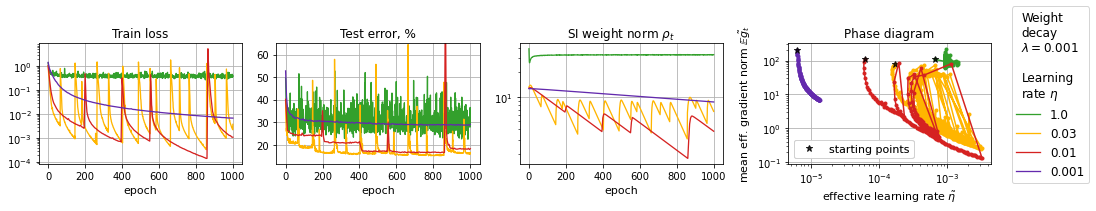

In [6]:
sns.set_palette(sns.color_palette(colors))
model_name = "ConvNetSI"
dataset_name = "CIFAR10"
fix_noninvlr = 0.0

if fix_noninvlr >= 0:
    folder_info = './Experiments/{}_{}_noninvlr_{}/info/'.format(model_name,dataset_name,fix_noninvlr) 
else:
    folder_info = "./Experiments/{}_{}/info/".format(model_name,dataset_name)
fns = listdir(folder_info)

lrs = ['lr1.0','lr0.01','lr0.03','lr0.001']

fns_tmp = []
for fn in fns:
    if ('mom0.0' in fn 
        and 'noaug' in fn and 'c32' in fn and 'scale10.0'in fn and 'wd0.001' in fn
        and sum([p in fn for p in lrs]) and 'tmp' not in fn):
        fns_tmp.append(fn)
fns = fns_tmp
fns.sort(reverse=True)
print(fns)

results_info = load_info(folder_info,fns,model_name=model_name)

from_id,to_id=0,1000
xscale,yscale='linear','log'
fig, axes = plt.subplots(1,4,figsize = (5.5*4/1.6,4.1*1/1.6),constrained_layout=True)
plot_one_grad_diagram_paper(results_info,fns,0,axes[3],from_id = from_id,to_id = to_id)
plot_one_loss_paper(results_info,fns,'train','loss',axes[0],yscale=yscale,xscale=xscale,
              from_id = from_id,to_id = to_id,title = 'Train loss')
plot_one_loss_paper(results_info,fns,'test','acc',axes[1],yscale='linear',xscale=xscale,
              from_id = from_id,to_id = to_id,title = 'Test error, %')
plot_one_loss_paper(results_info,fns,'train','prebn_pnorm',axes[2],yscale='log',xscale=xscale,
              from_id = from_id,to_id = to_id,title = 'SI weight norm '+r'$\rho_t$')

handles, labels = axes[0].get_legend_handles_labels()
for l in range(len(labels)):
    labels[l] = labels[l].split('_')[3][2:]
legend = axes[3].legend(handles,labels,loc=[1.1,-0.16],fontsize=12,
                        title = 'Weight\ndecay\n'+r'$\lambda = 0.001$'+'\n\nLearning\nrate '+r'$\eta$')
legend_stars = axes[3].legend([axes[3].get_legend_handles_labels()[0][1]],
                              [axes[3].get_legend_handles_labels()[1][1]],loc='lower left',fontsize=11)
legend.get_title().set_fontsize('12')

axes[3].add_artist(legend)
axes[3].add_artist(legend_stars)
axes[1].set_ylim(11.53,65)

#plt.savefig("figures/ConvNetSI32_cifar10_wd0.001_diff_lr_inv.pdf", bbox_inches='tight', format='pdf')